In [167]:
import pandas as pd
import data_utility
from textblob import TextBlob  
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

import matplotlib.pyplot as plt
from wordcloud import WordCloud

import os
import json
import dotenv
import requests

import spacy
from spacy import displacy
nlp = spacy.load("en_core_web_sm")

dotenv.load_dotenv()

True

In [147]:
# Read the data to dataframe
hotel_reviews_df = data_utility.get_hotel_reviews()
hotel_reviews_df.dropna(subset=['reviews.text'], axis=0, inplace=True)
hotel_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19786 entries, 0 to 19786
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    19786 non-null  object 
 1   dateAdded             19786 non-null  object 
 2   dateUpdated           19786 non-null  object 
 3   address               19786 non-null  object 
 4   categories            19786 non-null  object 
 5   primaryCategories     19786 non-null  object 
 6   city                  19786 non-null  object 
 7   country               19786 non-null  object 
 8   keys                  19786 non-null  object 
 9   latitude              19786 non-null  float64
 10  longitude             19786 non-null  float64
 11  name                  19786 non-null  object 
 12  postalCode            19786 non-null  object 
 13  province              19786 non-null  object 
 14  reviews.date          19786 non-null  object 
 15  reviews.dateSeen      19

/Users/Ajay/Development/AIBootcamp_Git/project3-group3-travel-assistant/src/data_utility.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  hotel_reviews_df = pd.concat(h_dfs).reset_index(drop=True)


## Sentiment analysis of reviews from users

In [148]:
def analyze_reviews(reviews):
    ''' 
        return sentiment analysis scores for provided reviews.
    '''
    sid = SentimentIntensityAnalyzer()

    # List to store sentiments
    sentiment_scores = [] 

    for each_review in reviews: 
        try:
            sentiment_scores.append(sid.polarity_scores(each_review))
        except Exception as ex:
            print(f'Review: {each_review} Error: {ex}')
    
    # Calculate the combined sentiment score by averaging the individual scores
    combined_score = {
        'Overall': sum(score['compound'] for score in sentiment_scores) / len(sentiment_scores),
        'Negative': sum(score['neg'] for score in sentiment_scores) / len(sentiment_scores),
        'Neutral': sum(score['neu'] for score in sentiment_scores) / len(sentiment_scores),
        'Positive': sum(score['pos'] for score in sentiment_scores) / len(sentiment_scores)
    }

    #print("Combined Sentiment Score:", combined_score)
    
    return combined_score

In [149]:
# get data of specific reviews to analyze
reviews_process = hotel_reviews_df \
                    [(hotel_reviews_df['city'].str.lower() == 'chicago') \
                        & (hotel_reviews_df['province'].str.lower() == 'il')
                        & (hotel_reviews_df['name'].str.contains("Inn At Lincoln Park"))]
reviews_process['reviews.text']

1435    The rooms at this hotel sort of look like some...
1436    The staff was excellent and friendly. The buil...
1437    I booked this hotel way in advance for the Bil...
1438    My friend said he liked the charm and age of o...
1439    On entry, the lobby was quite tired: old carpe...
Name: reviews.text, dtype: object

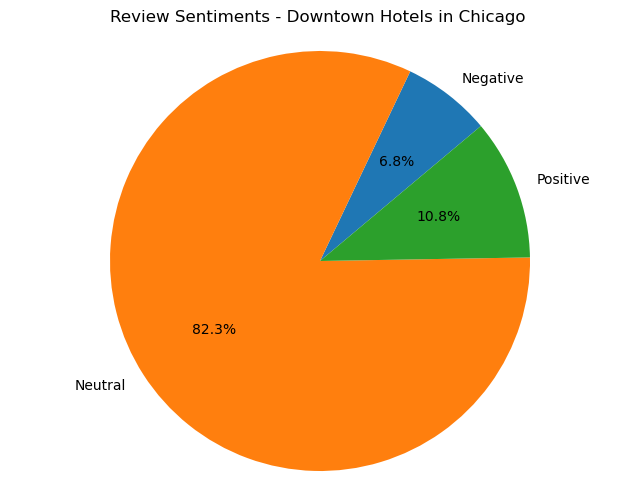

In [150]:
# test the reviews sentiments and plot as graph
sentiment_scores = {key: analyze_reviews(reviews_process['reviews.text'])[key] for key in ['Negative', 'Neutral', 'Positive']}

categories = list(sentiment_scores.keys())
scores = list(sentiment_scores.values())

# Create pie chart
plt.figure(figsize=(8, 6))
plt.pie(scores, labels=categories, autopct='%1.1f%%', startangle=40)
plt.axis('equal')
plt.title('Review Sentiments - Downtown Hotels in Chicago ')
plt.show()


In [151]:
#try with different module for sentiment analysis - Textblob
# this returns single score between -1 to 1 
# -1 to 0 - Negative, 0 to 1 - positive 
def analyze_reviews_tb(reviews):
    sentiment_scores = []

    for each_review in reviews: 
        try:
            sentiment_scores.append(TextBlob(each_review).sentiment.polarity)
        except Exception as ex:
            print(f'Review: {each_review} Error: {ex}')
    
    # Calculate the combined sentiment score by averaging the individual scores
    combined_score = sum(sentiment_scores) / len(sentiment_scores)

    #print("Combined Sentiment Score:", combined_score)
    return combined_score

In [152]:
# test the reviews sentiments and plot as graph
print(f"Reviews score using Textblob: {analyze_reviews_tb(reviews_process['reviews.text'])}")

Reviews score using Textblob: 0.17274591461929126


## Key words from reviews

In [153]:
# Create an instance of the TfidfVectorizer 
# define the English stopwords to be ignored.
custom_stop_words = ['did', 'said', 'like']

# Combine default English stop words with custom stop words
swords = list(set(stopwords.words('english')).union(custom_stop_words))

tfid_v = TfidfVectorizer(stop_words=swords)

X_tokens = tfid_v.fit_transform(reviews_process['reviews.text'])
print(X_tokens)

  (0, 149)	0.14212024955762195
  (0, 509)	0.14212024955762195
  (0, 524)	0.14212024955762195
  (0, 395)	0.14212024955762195
  (0, 420)	0.14212024955762195
  (0, 358)	0.14212024955762195
  (0, 12)	0.14212024955762195
  (0, 122)	0.1146617224812308
  (0, 308)	0.14212024955762195
  (0, 0)	0.14212024955762195
  (0, 460)	0.14212024955762195
  (0, 156)	0.14212024955762195
  (0, 87)	0.14212024955762195
  (0, 192)	0.14212024955762195
  (0, 281)	0.14212024955762195
  (0, 333)	0.09517958747665163
  (0, 63)	0.14212024955762195
  (0, 424)	0.14212024955762195
  (0, 359)	0.1146617224812308
  (0, 385)	0.14212024955762195
  (0, 51)	0.1146617224812308
  (0, 532)	0.1146617224812308
  (0, 15)	0.08006806956017341
  (0, 141)	0.14212024955762195
  (0, 105)	0.14212024955762195
  :	:
  (4, 123)	0.06509435873155323
  (4, 446)	0.05403419796122975
  (4, 483)	0.05403419796122975
  (4, 366)	0.06509435873155323
  (4, 102)	0.1080683959224595
  (4, 176)	0.06509435873155323
  (4, 401)	0.1080683959224595
  (4, 38)	0.065

In [154]:
# Create a list to hold the words
review_words = list(tfid_v.get_feature_names_out())

# Create a list to hold the frequency
word_freq = list(np.ravel(X_tokens.sum(axis=0)))

review_words_df = pd.DataFrame({'Word':review_words, 'Frequency':word_freq})
review_words_df_sorted = review_words_df.sort_values(by='Frequency', ascending=False).reset_index(drop=True)

# Print the top 10 words
review_words_df_sorted[:10]

,Word,Frequency
0,hotel,0.788243
1,parking,0.472806
2,room,0.451372
3,get,0.386440
4,water,0.377328
5,back,0.340768
6,night,0.338233
7,old,0.316868
8,rooms,0.294418
9,hot,0.290379


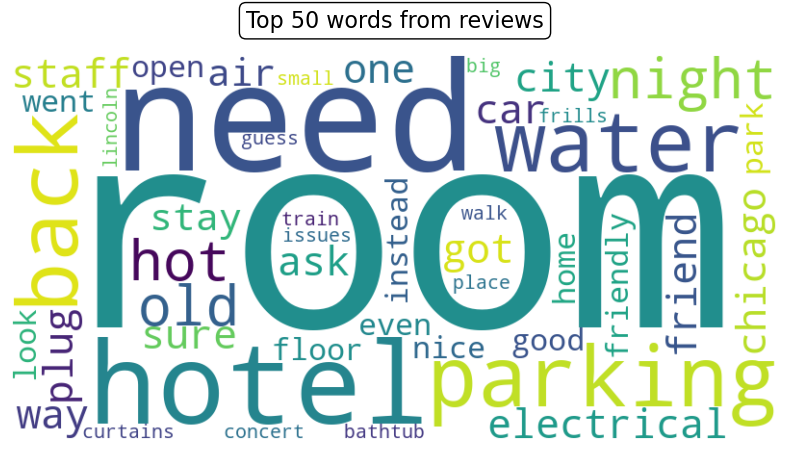

In [155]:
# Generate the word cloud image with top 50 words
wordcloud = WordCloud(width=800, height=400, background_color='white')\
    .generate(review_words_df_sorted['Word'][:50].str.cat(sep=' '))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

title = plt.title('Top 50 words from reviews', fontsize=16, pad=20)
title.set_bbox({'boxstyle': 'round', 'pad': 0.3, 'edgecolor': 'black', 'facecolor': 'white'})

plt.show()

## Functions to use in chatbot to get user input analyze and respond

In [156]:
def filter_hotels_by_city(city):
    '''
        return dataframe with specific city
        if city is in more than one state ask for state 
        by returing list of states that has same city name
    '''
    city_hotels = hotel_reviews_df[hotel_reviews_df['city'].str.lower() == city.lower()]

    if city_hotels.groupby(['city', 'province'])['province'].unique().count() > 1:
        return np.concatenate(city_hotels.groupby(['city', 'province'])\
                              ['province'].unique().to_list()).tolist()
    else:
        return city_hotels

def filter_hotels_by_city_state(city, state):
    '''
        return dataframe with specific city and state
    '''
    city_state_hotels = hotel_reviews_df[(hotel_reviews_df['city'].str.lower() == city.lower()) \
                                   & (hotel_reviews_df['province'].str.lower() == state.lower())]
        
    return city_state_hotels

def recommend_top_hotels(hotels_df, top_n=5):
    '''
        return list of top hotels
    '''
    top_hotels = hotels_df.groupby('name')['reviews.rating'].mean()\
        .sort_values(ascending=False).head(top_n)
    return top_hotels

def get_reviews(hotels_df):
    '''
        retrieve reviews from hotels and return
    '''
    return hotels_df['reviews.text']

In [157]:
# test functions 
city = 'springfield'

hotels_df = filter_hotels_by_city(city)

if type(hotels_df) == list:
    state = 'il'
    hotels_df = filter_hotels_by_city_state(city, state)

print(recommend_top_hotels(hotels_df))

print(get_reviews(hotels_df))


name
Residence Inn Springfield South    5.0
Name: reviews.rating, dtype: float64
7472     The staff is extremely friendly and always gre...
14925    The staff could not be kinder and more helpful...
14926    Check in was easy and the staff was friendly a...
14927    The front desk Manager Mark was beyond wonderf...
14928    We were in town for the Rte 66 car show and fo...
Name: reviews.text, dtype: object


In [158]:
# test the above sentiment analysis
print(analyze_reviews(hotels_df['reviews.text']))

{'Overall': 0.93864, 'Negative': 0.0228, 'Neutral': 0.6928000000000001, 'Positive': 0.2846}


## Using langchain and google try to get real time reviews and provide feedback to user

In [159]:
def search_places(query, selectedType, minRating): 
    '''
        Search hotels using google places api 
    '''
    #API endpoint
    url = 'https://places.googleapis.com/v1/places:searchText'

    includedTypes = ["extended_stay_hotel", "hotel", "lodging"]

    #headers
    headers = {
        'Content-Type': 'application/json',
        'X-Goog-Api-Key': os.environ.get('GOOGLE_API_KEY'), 
        'X-Goog-FieldMask': 'places.id,places.displayName,places.rating,places.reviews,places.websiteUri,places.types,places.primaryType'
    }

    #data payload for the POST request
    data = {
        'textQuery': selectedType + ' ' + query, 
        'maxResultCount': 5,
        'minRating': minRating,
        'strictTypeFiltering': True,
        'includedType': selectedType
    }

    hotel_details = []

    response = requests.post(url, headers=headers, json=data)

    # Check if the request was successful
    if response.status_code == 200:
        # Process the response
        if (type(json.loads(response.text)) == dict) and len(json.loads(response.text)) != 0:
            for eachPlace in json.loads(response.text)['places']:
                if (eachPlace["primaryType"] == selectedType):
                    details = {
                        'placeId': eachPlace['id'],
                        'name' : eachPlace['displayName']['text'],
                        'types' : eachPlace['types'] if 'types' in eachPlace else None,
                        'primaryType' : eachPlace['primaryType'] if 'primaryType' in eachPlace else None,
                        'website' : eachPlace['websiteUri'] if 'websiteUri' in eachPlace else None,
                        'rating' : eachPlace['rating'] if 'rating' in eachPlace else None,
                        'reviews' : eachPlace['reviews'] if 'reviews' in eachPlace else None        
                    }
                    
                    all_reviews = []
                    for eachReview in eachPlace['reviews']:
                        review_text = eachReview['text']['text']
                        all_reviews.append(review_text)
                        details['allReviews'] = (' '.join(all_reviews))

                    hotel_details.append(details)
            sorted_list = sorted(hotel_details, key=lambda x: x['rating'], reverse=True)
            print(f'Hotel Details List: {len(sorted_list)}')
    else:
        print(f"Error: {response.status_code}, {response.text}")
    return sorted_list

In [160]:
#test the function 
search_results = search_places("columbus oh", "extended_stay_hotel", 4)
search_results

Hotel Details List: 4


[{'placeId': 'ChIJbbQv3W2OOIgRzgR3lHlUyEM',
  'name': 'Homewood Suites by Hilton Columbus/OSU, OH',
  'types': ['extended_stay_hotel',
   'hotel',
   'lodging',
   'point_of_interest',
   'establishment'],
  'primaryType': 'extended_stay_hotel',
  'website': 'https://www.hilton.com/en/hotels/cmhlahw-homewood-suites-columbus-osu-oh/?SEO_id=GMB-AMER-HG-CMHLAHW&y_source=1_MjA4MjUzNC03MTUtbG9jYXRpb24ud2Vic2l0ZQ%3D%3D',
  'rating': 4.4,
  'reviews': [{'name': 'places/ChIJbbQv3W2OOIgRzgR3lHlUyEM/reviews/ChdDSUhNMG9nS0VJQ0FnSURON1Ayam53RRAB',
    'relativePublishTimeDescription': '3 months ago',
    'rating': 5,
    'text': {'text': 'Excellent rooms and service! Comfortable beds nice dark and quiet room. Got really good nights sleep 💤 . Room was very roomy. Everything in excellent working order.  Great location. Tons of awesome places to eat nearby even within walking distance. Friendly staff. Highly recommended!',
     'languageCode': 'en'},
    'originalText': {'text': 'Excellent rooms and 

In [161]:
from icecream import ic

from langchain.chains import AnalyzeDocumentChain
from langchain.chat_models import ChatOpenAI
from langchain.chains.question_answering import load_qa_chain

def analyze_reviews(review_data, review_prompt):
    ''' 
        Function to process hotel reviews based on the prompt provided using Langchain, 
        ChatOpenAI and QA chains form langchain. 

        Prompt Examples: 
        Which of the hotels has the best reviews and why do you think that? You must make a choice
        and choose one hotel and provide reasoning behind it. 

        Analyze the reiviews of the hotel, and tell which has the positive sentiment? Based on sentiment 
        analysis recommend top 3 hotels? And provide the sentiment scores for each hotel?

    '''
    llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)

    qa_chain = load_qa_chain(llm, chain_type="map_reduce")
    qa_document_chain = AnalyzeDocumentChain(combine_docs_chain=qa_chain)
    ans = qa_document_chain.run(
        input_document=review_data, 
        question=review_prompt)
    return ans

In [165]:
#test this method
r_prompt = """
    Which of the hotels has the best reviews and why do you think that? You must make a choice
    and choose one hotel and provide reasoning behind it. 
"""

r_prompt1 = """
    what are the main key words in the reviews? And is it negative or positive? 
"""

for eachHotel in search_results:
    ic(eachHotel['name'])
    review_display = analyze_reviews(eachHotel['allReviews'], r_prompt1)
    ic(review_display)

ic| eachHotel['name']: 'Homewood Suites by Hilton Columbus/OSU, OH'
ic| review_display: ('The main keywords in the reviews are: rooms, service, comfortable beds, '
                     'sleep, location, staff, recommended, spacious, out of date, uncomfortable '
                     'couches, breakfast, powdered eggs, strong coffee, in-room coffee, AC/heat, '
                     'bathrooms, parking, restaurants nearby, clean, convenient location, issues, '
                     'diamond member, non-English speaking staff, rude, disturbing, communication, '
                     'size of the room, PR, Hilton name, two stars, Ohio State Vet Hospital, '
                     'location, dining options, Whole Foods, helpful staff, accommodating, kind.
                    '
                     '
                    '
                     'The reviews contain a mix of negative and positive feedback. Positive '
                     'aspects include excellent service, comfortable beds, good sleep